In [3]:
import numpy as np
import pandas as pd
import sys, os, math
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from scipy.special import expit
from sklearn.datasets import load_digits
from sklearn.preprocessing import OneHotEncoder
from scipy.special import expit
from sklearn.metrics import accuracy_score
%matplotlib inline
%reload_ext autoreload
%autoreload 2

/Users/DS/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
#Load Data
digits = load_digits()
digits_data = digits.data / 16

#Train Test split
X_train, X_test, y_train, y_test = train_test_split(digits_data, digits.target, test_size=0.1, random_state=1)

#One hot encoding
ohe = OneHotEncoder(n_values=10)
y_train_enc = ohe.fit_transform(y_train.reshape(-1, 1)).toarray()

### Using Batch,Relu,cyclic learning rate on digits dataset  - And Adam Optimizer

In [10]:
class mNN():
    def __init__(self,lr,layer_no_actv,bs,epochs,cyclic_lr=False):
        self.lr = lr
        self.layer_no_actv = layer_no_actv # number activations per layer 
        self.bs = bs # Batch size
        self.bias_weights = []
        self.layers_weights = []
        self.layer_input=[]
        self.layer_output =[]
        self.pd_weights =[] #partial derivatives of weights
        self.pd =[] # partial derivatives of error at each layer
        self.pd_h_in =[] #partial derivaties of each layer input
        self.pd_h_out =[] # partial derivaties of each layer output
        self.pd_bias = [] #partial derivatives of bias        
        self._x = None
        self.enable_adam  = False
        self.cyclic_lr = cyclic_lr
        
        
        #Weights initializqtion using np.uniform ,we have only one hidden layer and two weight arrays
        for i in range(len(self.layer_no_actv)-1):
            np.random.seed(1)
            bound = np.sqrt(1./self.layer_no_actv[i+1])
            self.layers_weights.append(np.random.uniform(-bound, bound, size=(self.layer_no_actv[i],self.layer_no_actv[i+1])))
            bound = np.sqrt(1./self.layer_no_actv[i+1])
            self.bias_weights.append(np.random.uniform(-bound, bound, self.layer_no_actv[i+1]))

            #Partial derivatives initialze lists with Blank.
            self.pd.append(None)
            self.pd_weights.append(None)
            self.pd_bias.append(None)
            self.pd_h_in.append(None)
            self.pd_h_out.append(None) 
            self.pd.append(None)

    def relu(self,x):
        relux = np.maximum(x,0)
        return relux
    
    def reluGradient(self,z):
        temp = np.copy(z)
        temp[temp>0] = 1
        temp[temp<=0] = 0
        return temp
    
    def softmax(self,x):
        exps = np.exp(x - x.max(axis=1).reshape(-1, 1))
        return (exps/(np.sum(exps,axis=1)).reshape(-1,1))
                
    def forward(self,X):
        x = np.copy(X)
        #inputs as first layer inputs and outputs since there is no activation function on input layer
        self.layer_input.append(x) 
        self.layer_output.append(x) 
        
        for i in range(len(self.layers_weights)):
            x = np.dot(x,self.layers_weights[i])+self.bias_weights[i]
            self.layer_input.append(x)
            if i < len(self.layers_weights)-1:
                x = self.relu(x)
            else:
                x = self.softmax(x)
            self.layer_output.append(x)
        return x

        
    def backward(self,y_pred,y,lr):
        no_of_layers = len(self.layer_output)
        no_of_weights = no_of_layers -1
        i =no_of_weights-1 # python index starts with 0 .

        #Calculate last layer outside the loop
        self.pd[i] = self.layer_output[no_of_weights] - y 
        self.pd_bias[i] = np.average(self.pd[i],axis=0)
        self.pd_weights[i] = (1/self.bs) * self.layer_output[i].T.dot(self.pd[i])
        
        for i in range(no_of_weights-2,-1,-1): # since we have already calculated last layer derivative we need to start from next layer
            delta = self.pd[i+1] # previous layer error
            
            # calculate current layer derivate with previous layer derivative
            self.pd_h_out[i] = delta.dot(self.layers_weights[i+1].T) 
            
            # calculate current layer input with derivative of activation function.
            self.pd_h_in[i]= self.pd_h_out[i] *  self.reluGradient(self.layer_output[i+1]) 
            
            #Current layer input derivative will be used as derivaitve to next layer.
            self.pd[i] =self.pd_h_in[i]
            
            self.pd_bias[i] = np.average(self.pd[i],axis=0)
            self.pd_weights[i] = (1/self.bs) * self.layer_output[i].T.dot(self.pd[i])
            
    def backward_manual(self,y_pred,y,lr):
    # Manual Gradient calculation for understanding. enable only for two hidden layers.
    
        pd_output = self.layer_output[3] - y
        pd_h2_out = pd_output.dot(self.layers_weights[2].T)
        pd_h2_in = pd_h2_out *  self.reluGradient(self.layer_output[2])
        pd_h1_out = pd_h2_in.dot(self.layers_weights[1].T)
        pd_h1_in = pd_h1_out *  self.reluGradient(self.layer_output[1])

        self.pd_weights[2] = (1/self.layer_input[0].shape[0]) * self.layer_output[2].T.dot(pd_output)
        self.pd_weights[1] = (1/self.layer_input[0].shape[0]) * self.layer_output[1].T.dot(pd_h2_in)
        self.pd_weights[0] = (1/self.layer_input[0].shape[0]) * self.layer_output[0].T.dot(pd_h1_in)

        self.pd_bias[2] = np.average(pd_output,axis=0)        
        self.pd_bias[1] = np.average(pd_h2_in,axis=0)
        self.pd_bias[0] = np.average(pd_h1_in,axis=0)


        
    def update_grads(self,lr):
        for i in range(len(self.layers_weights)):
            if i == (len(self.layers_weights)-1):
                local_lr = self.lr
            else:
                local_lr = lr
            self.layers_weights[i] -= local_lr * self.pd_weights[i]
            self.bias_weights[i] -= local_lr * self.pd_bias[i]
        
    def predict(self,X):
        x = np.copy(X)
        for i in range(len(self.layers_weights)):
            x = np.dot(x,self.layers_weights[i]) 
            if i < len(self.layers_weights)-1:
                x = self.relu(x)
            else:
                x = self.softmax(x)
        x = np.argmax(x,axis=1)
        return x 
    def adam_opt(self,t):
        for i in range(len(self.mom_v)):
            self.mom_v[i],self.rms_v[i],self.pd_weights[i] = self.adam(self.mom_v[i],self.rms_v[i],self.pd_weights[i],t)
            self.mom_bv[i],self.rms_bv[i],self.pd_bias[i] = self.adam(self.mom_bv[i],self.rms_bv[i],self.pd_bias[i],t)
            
    def adam(self,mom_prev,rms_prev,grad,t):
        mom_prev = mom_prev*self.mom_beta + (1-self.mom_beta)*grad
        rms_prev = rms_prev*self.rms_beta + (1- self.rms_beta) * (grad*grad)
        
        mom_prev = mom_prev/(1-self.mom_beta**t) #bias corretion
        rms_prev = rms_prev/(1-self.rms_beta**t) #bias correction

        grad = mom_prev/(np.sqrt(rms_prev)+self.eps)
        return mom_prev,rms_prev,grad
        
    def set_adam_params(self,mom,rms,eps):
        self.enable_adam = True
        self.mom_beta = mom
        self.rms_beta = rms
        self.eps = eps 
        self.mom_v = []
        self.rms_v = []
        self.mom_bv = []
        self.rms_bv = []
        for i in range(len(self.pd_weights)):
            self.mom_v.append(0)
            self.rms_v.append(0)
            self.mom_bv.append(0)
            self.rms_bv.append(0)
    
    def train(self, X, y,X_test,y_test,cost,accuracy,epochs):
        #Batch creation
        bs_iterations = X.shape[0]//self.bs
        
        lr = np.arange(self.lr,0.1+self.lr,0.1/(epochs/2))
        lr = np.concatenate([lr,lr[::-1]],axis=0)

        t = 0 #Adam iteration number

        for epoch in range(epochs):
            loop_cost = []
            for i in range(bs_iterations):
                start=i*self.bs
                end = i*self.bs+self.bs
                t+=1
                if self.cyclic_lr:
                    loop_lr = lr[epoch]
                else:
                    loop_lr= self.lr

                #Forward
                y_pred = self.forward(X[start:end,:]) 

                #Backpropogation
                self.backward(y_pred,y[start:end,:],loop_lr)
                
                #adam opt
                if self.enable_adam:
                    self.adam_opt(t)
                    
                #update weights
                self.update_grads(loop_lr)
                
                #reset layer output and inputs
                self.layer_output = []
                self.layer_input = []

                y_pred = np.clip(y_pred, 0.00001, 0.99999)
                loop_cost.append(-np.sum(y[start:end,:] * np.log(y_pred))/y.shape[0])
            cost.append(np.sum(loop_cost)/(bs_iterations*self.bs))
            
            
            #Validation
            y_pred = self.predict(X_test)
            accuracy.append(accuracy_score(y_test, y_pred))

Basic NN 
1. with Bias
2. One Hidden layers option

Cost : 0.0013763034    Training : 0.17996    Accuracy : 0.17222



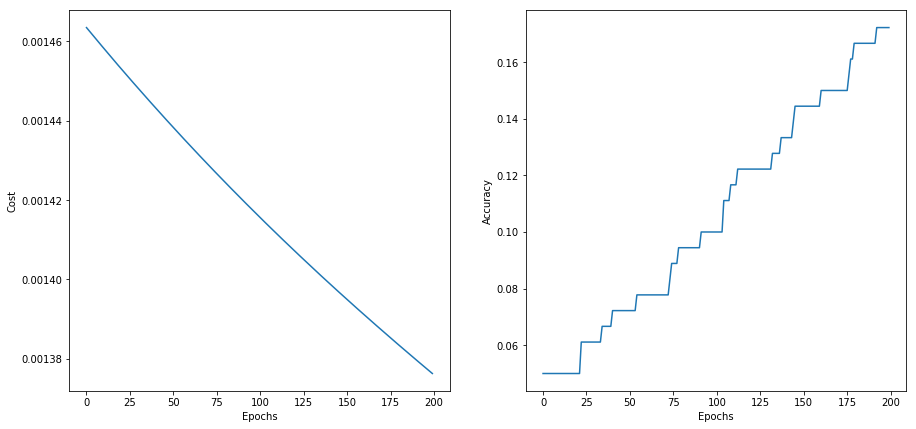

In [203]:
#Cost and Accuracy 
cost =[]
accuracy = []

#Hyperparameters
epochs = 200 # number of itearations
lr = 0.001
n_hl_units =[X_train.shape[1],150,y_train_enc.shape[1]] #inputlayer + hidden_layers + output_layer
bs=X_train.shape[0]


#Model initialization
mnn = mNN(lr,n_hl_units,bs,epochs) #set initial parameters to neural network

#Train
mnn.train(X_train,y_train_enc,X_test,y_test,cost,accuracy,epochs)

#Training and Validation costs 
y_pred = mnn.predict(X_train)
print("Cost :",round(cost[len(cost)-1],10 ),"   Training :",round(accuracy_score(y_train,y_pred),5),"   Accuracy :",round(accuracy[len(accuracy)-1],5))

#Plot cost and accuracy
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,7))
ax1.plot(cost)
ax1.set_ylabel("Cost")
ax1.set_xlabel("Epochs")
print()
ax2.plot(accuracy)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

Basic NN 
1. with Bias
2. One Hidden layers option
3. Batch processing

Cost : 0.0007066519    Training : 0.88188    Accuracy : 0.88333



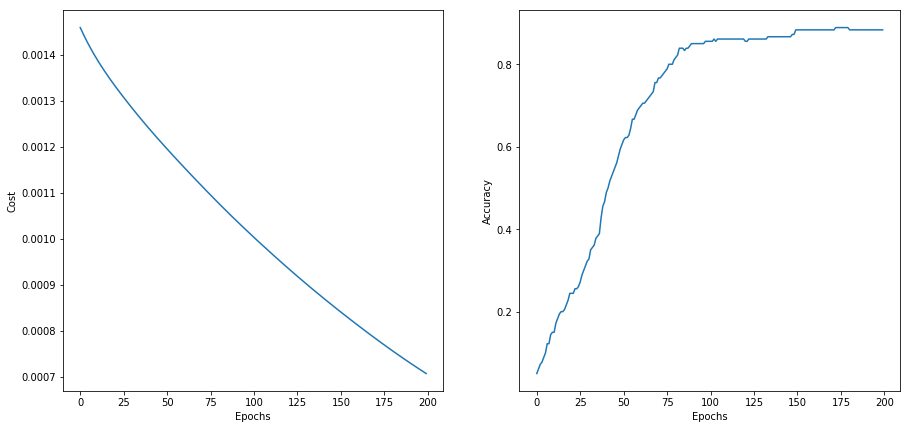

In [49]:
#Cost and Accuracy 
cost =[]
accuracy = []

#Hyperparameters
epochs = 200 # number of itearations
lr = 0.001
n_hl_units =[X_train.shape[1],150,y_train_enc.shape[1]] #inputlayer + hidden_layers + output_layer
bs=100

#Model initialization
mnn = mNN(lr,n_hl_units,bs,epochs) #set initial parameters to neural network

#Train
mnn.train(X_train,y_train_enc,X_test,y_test,cost,accuracy,epochs)

#Training and Validation costs 
y_pred = mnn.predict(X_train)
print("Cost :",round(cost[len(cost)-1],10 ),"   Training :",round(accuracy_score(y_train,y_pred),5),"   Accuracy :",round(accuracy[len(accuracy)-1],5))

#Plot cost and accuracy
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,7))
ax1.plot(cost)
ax1.set_ylabel("Cost")
ax1.set_xlabel("Epochs")
print()
ax2.plot(accuracy)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

Basic NN 
1. with Bias
2. One Hidden layers option
3. Batch processing
4. cyclic learning rate

Cost : 3.32182e-05    Training : 0.98578    Accuracy : 0.97778



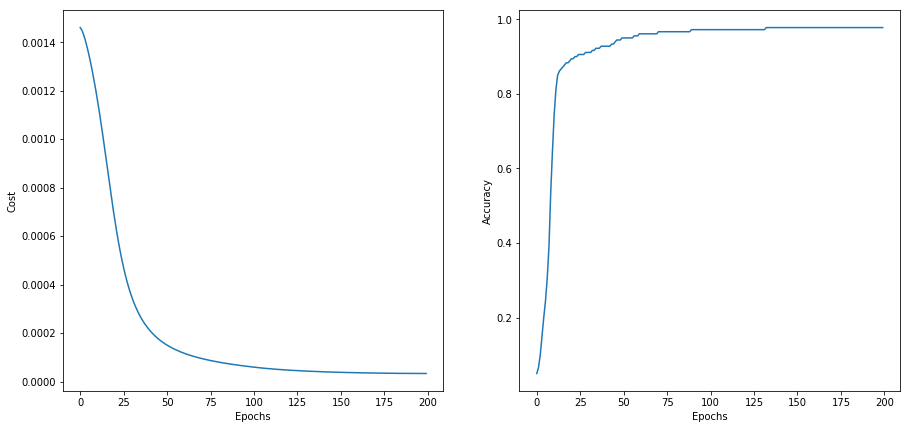

In [50]:
#Cost and Accuracy 
cost =[]
accuracy = []

#Hyperparameters
epochs = 200 # number of itearations
lr = 0.001
n_hl_units =[X_train.shape[1],150,y_train_enc.shape[1]] #inputlayer + hidden_layers + output_layer
bs=100


#Model initialization
mnn = mNN(lr,n_hl_units,bs,epochs,cyclic_lr=True) #set initial parameters to neural network

#Train
mnn.train(X_train,y_train_enc,X_test,y_test,cost,accuracy,epochs)

#Training and Validation costs 
y_pred = mnn.predict(X_train)
print("Cost :",round(cost[len(cost)-1],10 ),"   Training :",round(accuracy_score(y_train,y_pred),5),"   Accuracy :",round(accuracy[len(accuracy)-1],5))

#Plot cost and accuracy
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,7))
ax1.plot(cost)
ax1.set_ylabel("Cost")
ax1.set_xlabel("Epochs")
print()
ax2.plot(accuracy)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

Basic NN 
1. with Bias
2. One Hidden layers option
3. Batch processing
4. cyclic learning rate
5. Adam optimization

Cost : 6.2e-09    Training : 0.99567    Accuracy : 0.97778



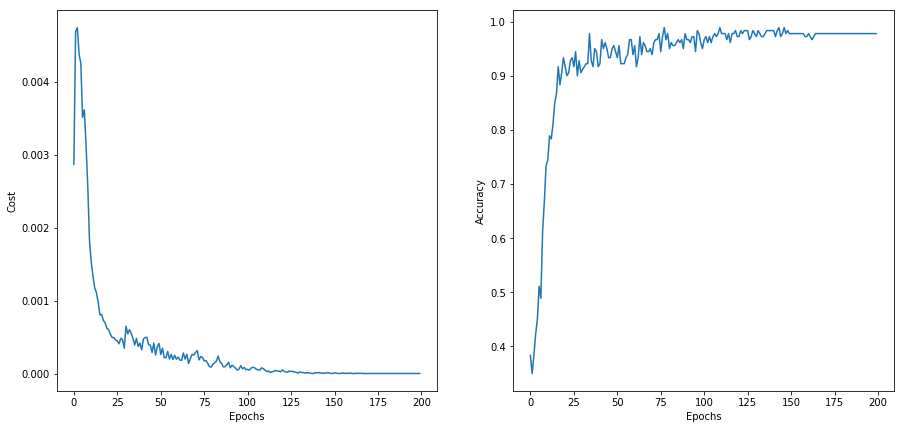

In [51]:
#Cost and Accuracy 
cost =[]
accuracy = []

#Hyperparameters
epochs = 200 # number of itearations
lr = 0.001
n_hl_units =[X_train.shape[1],150,y_train_enc.shape[1]] #inputlayer + hidden_layers + output_layer
bs=100
v_beta = 0.9 #momentum
s_beta = 0.888 #RMS prop
epsilon =10**-8

#Model initialization
mnn = mNN(lr,n_hl_units,bs,epochs,cyclic_lr=True) #set initial parameters to neural network
#adam properties initialization
mnn.set_adam_params(v_beta,s_beta,epsilon)#default mom = 0.9,rms =0.999 ,eps =10**-8
#Train
mnn.train(X_train,y_train_enc,X_test,y_test,cost,accuracy,epochs)

#Training and Validation costs 
y_pred = mnn.predict(X_train)
print("Cost :",round(cost[len(cost)-1],10 ),"   Training :",round(accuracy_score(y_train,y_pred),5),"   Accuracy :",round(accuracy[len(accuracy)-1],5))

#Plot cost and accuracy
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,7))
ax1.plot(cost)
ax1.set_ylabel("Cost")
ax1.set_xlabel("Epochs")
print()
ax2.plot(accuracy)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()

Basic NN 
1. with Bias
2. One Hidden layers option
3. Batch processing
4. cyclic learning rate
5. Adam optimization
6. batch size reduced

Cost : 7.58738e-05    Training : 0.76747    Accuracy : 0.78333



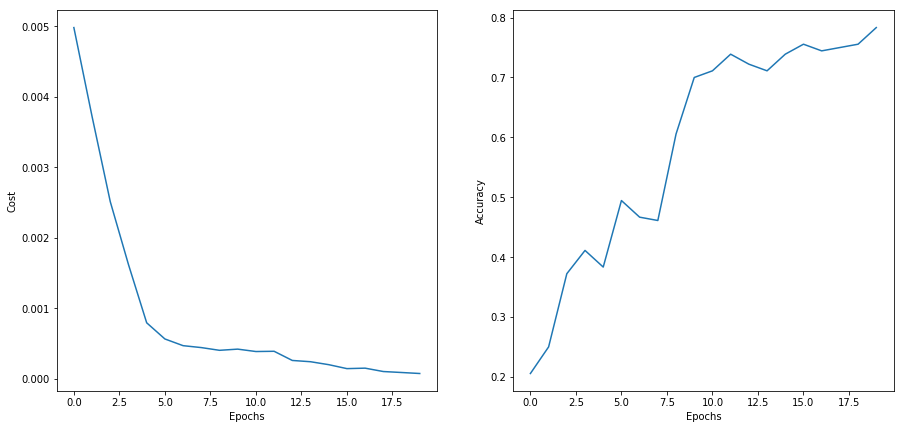

In [205]:
#Cost and Accuracy 
cost =[]
accuracy = []

#Hyperparameters
epochs = 200 # number of itearations
lr = 0.001
n_hl_units =[X_train.shape[1],150,y_train_enc.shape[1]] #inputlayer + hidden_layers + output_layer
bs=10
v_beta = 0.9 #momentum
s_beta = 0.888 #RMS prop
epsilon =10**-8

#Model initialization
mnn = mNN(lr,n_hl_units,bs,epochs,cyclic_lr=True) #set initial parameters to neural network
#adam properties initialization
mnn.set_adam_params(v_beta,s_beta,epsilon)#default mom = 0.9,rms =0.999 ,eps =10**-8
#Train
mnn.train(X_train,y_train_enc,X_test,y_test,cost,accuracy,epochs)

#Training and Validation costs 
y_pred = mnn.predict(X_train)
print("Cost :",round(cost[len(cost)-1],10 ),"   Training :",round(accuracy_score(y_train,y_pred),5),"   Accuracy :",round(accuracy[len(accuracy)-1],5))

#Plot cost and accuracy
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,7))
ax1.plot(cost)
ax1.set_ylabel("Cost")
ax1.set_xlabel("Epochs")
print()
ax2.plot(accuracy)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()



Basic NN 
1. with Bias
2. multiple Hidden layers option
3. Batch processing
4. cyclic learning rate
5. Adam optimization
6. batch size reduced

Cost : 6.2e-09    Training : 0.99938    Accuracy : 0.98889



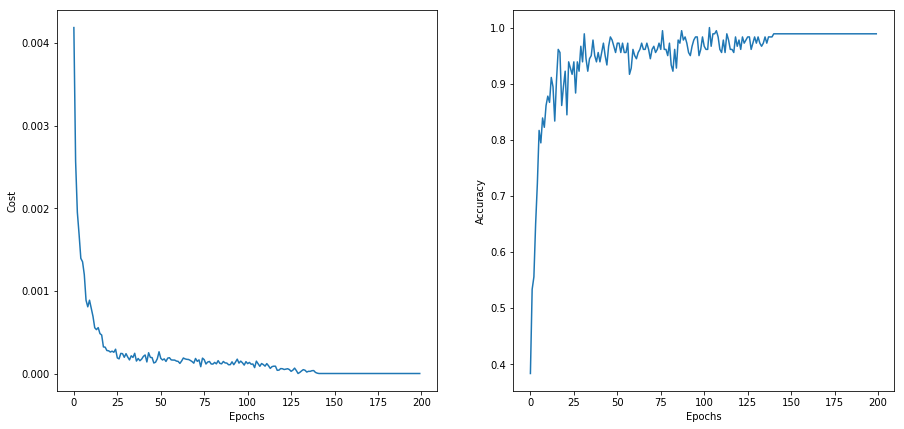

In [14]:

#Cost and Accuracy 
cost =[]
accuracy = []

#Hyperparameters
epochs = 200 # number of itearations
lr = 0.001
n_hl_units =[X_train.shape[1],150,150,y_train_enc.shape[1]] #inputlayer + hidden_layers + output_layer
bs=10
v_beta = 0.9 #momentum
s_beta = 0.888 #RMS prop
epsilon =10**-8

#Model initialization
mnn = mNN(lr,n_hl_units,bs,epochs,cyclic_lr=True) #set initial parameters to neural network

#adam properties initialization
mnn.set_adam_params(v_beta,s_beta,epsilon)#default mom = 0.9,rms =0.999 ,eps =10**-8
#Train
mnn.train(X_train,y_train_enc,X_test,y_test,cost,accuracy,epochs)

#Training and Validation costs 
y_pred = mnn.predict(X_train)
print("Cost :",round(cost[len(cost)-1],10 ),"   Training :",round(accuracy_score(y_train,y_pred),5),"   Accuracy :",round(accuracy[len(accuracy)-1],5))

#Plot cost and accuracy
fig,[ax1,ax2] = plt.subplots(1,2,figsize=(15,7))
ax1.plot(cost)
ax1.set_ylabel("Cost")
ax1.set_xlabel("Epochs")
print()
ax2.plot(accuracy)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Accuracy")
plt.show()